<a href="https://colab.research.google.com/github/IsaacFigNewton/Cyclic-Decision-Graph-Generator/blob/main/KNN_Estimation_of_Feature_Probability_Distributions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries and Config

In [1]:
import numpy as np
from collections import defaultdict
import pandas as pd
from itertools import permutations, product
import matplotlib.pyplot as plt

import sklearn as sk
from sklearn.neighbors import KernelDensity
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score,\
                                      recall_score,\
                                      accuracy_score,\
                                      f1_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y,\
                                     check_is_fitted,\
                                     check_array

In [2]:
# Prepare for k-fold cross-validation
n_splits = 2
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
colormap = {
    0: 'red',
    1: 'green'
}
class_map = dict()

# Lists to store evaluation metrics
precisions, recalls, accuracies, f1_scores = [], [], [], []

# Important Functions

## Probability Mass Function Estimator Class

In [34]:
class PMFRegressor(ClassifierMixin, BaseEstimator):

    def __init__(self, alpha=1e-9, n_neighbors=1):
        # minimum weighted probability (0 implies that the feature of datapoints belonging to a class never takes on a given value)
        self.alpha = alpha
        #Number of neighbors to use in KNN estimation
        self.n_neighbors = n_neighbors
        self.classes_ = None
        self.X_ = None
        self.y_ = None
        self.prior_class_probabilities = None
        self.feature_distribution = None
        self.pmf_store = None


    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)

        self.X_ = X
        self.y_ = y
        self.classes_ = np.unique(y)

        print("X:")
        print(X[:5])
        print("y:")
        print(y[:5])

        # Estimate the probability mass function
        self.prior_class_probabilities, self.feature_distribution, self.pmf_store = self.get_prob_distribution()

        # Return the classifier
        return self


    def predict(self, X):
        # Check if fit has been called
        check_is_fitted(self)
        # Input validation
        X = check_array(X)
        y = np.empty(X.shape[0], dtype=self.classes_.dtype)

        for i in range(X.shape[0]):
            datapoint = {j: X[i, j] for j in range(X.shape[1])}
            class_probabilities = self.calculate_class_probabilities(datapoint)
            predicted_class = max(class_probabilities, key=class_probabilities.get)
            y[i] = predicted_class

        return y



    # Main functions
    #*******************************************************************************************************************************************

    def get_prob_distribution(self):
        prior_class_probabilities = {class_value: self.get_prior_probability(class_value) for class_value in self.classes_}
        # create a multilevel dict to represent the weighted probabilities of every unique value of every feature for every class
        feature_distribution = {class_value: {feature: {} for feature in range(self.X_.shape[1])} for class_value in self.classes_}
        # create a dict to hold the global probabilities of every unique value in every feature
        global_unique_val_probabilities = {feature: {} for feature in range(self.X_.shape[1])}
        # create a dict to store PMFs for each feature and unique value
        pmf_store = {class_value: {feature: defaultdict() for feature in range(self.X_.shape[1])} for class_value in self.classes_}

        # Calculating and storing PMFs
        for feature in range(self.X_.shape[1]):
            # Get unique values for the current feature
            unique_values = np.unique(self.X_[:, feature])
            # Calculate the weighted probability for each unique value
            for unique_value in unique_values:
                # Calculate the probability distribution for the current feature and unique value
                prob_distribution, p_unique = self.calculate_weighted_prob(unique_value, feature)

                # Add the weighted probabilities of the unique value to the feature distribution set
                for class_value in self.classes_:
                    feature_distribution[class_value][feature][unique_value] = prob_distribution[class_value]

                    # Create a KNN for the current feature
                    pmf = self.create_pmf_using_knn(class_value, feature, feature_distribution)

                    # Store the KNN for the current feature and class
                    pmf_store[class_value][feature] = pmf

                # Store the probability distribution for the current feature and unique value
                global_unique_val_probabilities[feature][unique_value] = p_unique

        return prior_class_probabilities, feature_distribution, pmf_store


    # Function to get prior probability of the class
    def get_prior_probability(self, class_value):
        return np.sum(self.y_ == class_value) / len(self.X_)


    # Function to calculate probability distribution
    def calculate_weighted_prob(self, unique_value, feature):
        weighted_prob = {}

        # Calculate the probability of the unique value in the dataset as a whole
        mask = self.X_[:, feature] == unique_value
        p_unique = np.sum(mask) / len(self.X_)

        for class_value in self.classes_:
            # Filter the dataset for the current class and feature value
            class_mask = self.y_ == class_value
            class_data_mask = mask & class_mask

            p_unique_given_class = np.sum(class_data_mask) / np.sum(class_mask)

            # Avoid division by zero
            if p_unique > 0:
                weighted_prob[class_value] = p_unique_given_class / p_unique
            else:
                # No data for this unique value
                weighted_prob[class_value] = self.alpha

        return weighted_prob, p_unique


    # Function to create PMF using KNN
    def create_pmf_using_knn(self, class_value, feature, prob_distribution):
        # Get the values for the current feature and class
        values = np.array(list(prob_distribution[class_value][feature].keys())).reshape(-1, 1)
        # Get the weighted probabilities for the current feature and class
        probabilities = np.array(list(prob_distribution[class_value][feature].values()))

        # Create a kernel density estimator using Gaussian kernel
        knn = KNeighborsRegressor(n_neighbors=self.n_neighbors).fit(values, probabilities)

        return knn


    # Function to calculate P(class | feature1_value /\ feature2_value /\ …)
    def calculate_class_probabilities(self, feature_values):
        class_probabilities = {class_value: 1 for class_value in self.prior_class_probabilities.keys()}

        for class_value in self.prior_class_probabilities.keys():
            likelihood = 1
            for feature, value in feature_values.items():
                feature_likelihood = self.pmf_store[class_value][feature].predict(np.array([[value]]))
                # Accumulate features' weighted probabilities
                likelihood *= feature_likelihood

            # Get final class probability
            class_probability = likelihood * self.prior_class_probabilities[class_value]
            class_probabilities[class_value] = class_probability

        return class_probabilities



    # Helper functions
    #*******************************************************************************************************************************************

    # Map the features' weighted probability distributions to lists of features' values and their weighted probabilities
    def feature_distribution_to_dict(self):
        return {
            class_value: {
                feature: (list(self.feature_distribution[class_value][feature].keys()),
                          list(self.feature_distribution[class_value][feature].values()))
                for feature in range(self.X_.shape[1])
            } for class_value in self.classes_
        }


    def print_weighted_prob_dist(self):
        print("Feature Distribution:")
        print(self.feature_distribution_to_dict())

## Utility

In [6]:
def print_tree(tree, indent=0):
    # Iterate over the keys (features) in the tree
    for key, value in tree.items():
        print(' ' * indent + str(key))
        # If the value is a dictionary, recursively print the subtree
        if isinstance(value, dict):
            print_tree(value, indent + 4)
        else:
            print(' ' * (indent + 4) + str(value))

# Import and Clean Dataset

In [8]:
# Load the dataset
# Titanic
dataset = pd.read_csv("https://raw.githubusercontent.com/dlsun/pods/master/data/titanic.csv")
dataset.drop(columns=["name", "ticketno", "gender", "embarked", "class", "country"], inplace=True)
dataset.dropna(inplace=True)

# Identify categorical, continuous, and binary columns
X = ["age", "fare"]
y = ['survived']
class_map = {key: i for i, key in enumerate(dataset[y[0]].unique())}

dataset.head()

,age,fare,survived
0,42.0,7.11,0
1,13.0,20.05,0
2,16.0,20.05,0
3,39.0,20.05,1
4,16.0,7.13,1


# Data Exploration

## Preprocessing

In [51]:
# Parse the loose JSON representation into a dataframe

# Initialize an empty list to store the rows
rows = []

# Iterate through the dictionary to extract the data
for class_value, features in feature_distribution_x_y.items():
    for feature, (x_values, y_values) in features.items():
        # Create a DataFrame for the current feature
        df_feature = pd.DataFrame({
            'Class': class_value,
            'Feature': feature,
            'Feature Value': x_values,
            'Weighted Probability': y_values
        })
        # Append the DataFrame to the rows list
        rows.append(df_feature)

# Concatenate all rows into a single DataFrame
df = pd.concat(rows, ignore_index=True)

df

NameError: name 'feature_distribution_x_y' is not defined

In [ ]:
feature_1_df = df[df["Feature"] == "Feature 1"]
feature_2_df = df[df["Feature"] == "Feature 2"]

feature_1_df

## Figures

In [ ]:
# Create a scatter plot of the features' probability distribution
plt.scatter(feature_2_df['Feature Value'], feature_2_df['Weighted Probability'], c=feature_2_df[y[0]].map(colormap))

# Add labels and title
plt.xlabel('Feature Value')
plt.ylabel('Weighted Probability')
plt.show()

plt.scatter(feature_1_df['Feature Value'], feature_1_df['Weighted Probability'], c=feature_1_df[y[0]].map(colormap))

# Add labels and title
plt.xlabel('Feature Value')
plt.ylabel('Weighted Probability')
plt.show()

# Cross Validation Against other Models

In [35]:
dataset.head()

,age,fare,survived
0,42.0,7.11,0
1,13.0,20.05,0
2,16.0,20.05,0
3,39.0,20.05,1
4,16.0,7.13,1


## Sklearn DT Classifier

In [36]:
# Create a pipeline with preprocessor and DecisionTreeClassifier
pipeline = Pipeline(steps=[
    ('classifier', DecisionTreeClassifier())
])

In [37]:
# Split the data into training and test sets
fold = 1
for train_index, test_index in kf.split(dataset):
    print(f"Fold {fold}")

    # Split the data
    train_data = dataset.iloc[train_index]
    print(train_data.head())
    test_data = dataset.iloc[test_index]

    # Train the pipeline
    pipeline.fit(train_data[X], train_data[y[0]])

    # Predict and evaluate the model
    y_true = test_data[y]
    y_pred = pipeline.predict(test_data[X])

    # Calculate metrics using sklearn
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    precisions.append(precision)
    recalls.append(recall)
    accuracies.append(accuracy)
    f1_scores.append(f1)

    # # Print the decision tree
    # print_tree(tree)
    # print()

    # print(f"Precision: {precision:.4f}")
    # print(f"Recall: {recall:.4f}")
    # print(f"Accuracy: {accuracy:.4f}")
    # print(f"F1 Score: {f1:.4f}")
    # print()

    # Increment the fold index
    fold += 1

Fold 1
     age     fare  survived
0   42.0   7.1100         0
1   13.0  20.0500         0
4   16.0   7.1300         1
8   27.0  18.1509         1
11  27.0   8.0100         0
Fold 2
    age   fare  survived
2  16.0  20.05         0
3  39.0  20.05         1
5  25.0   7.13         1
6  30.0  24.00         0
7  28.0  24.00         1



Average Scores:
Precision: 0.6626 (+/- 0.0276)
Recall: 0.6672 (+/- 0.0243)
Accuracy: 0.6672 (+/- 0.0243)
F1 Score: 0.6458 (+/- 0.0347)


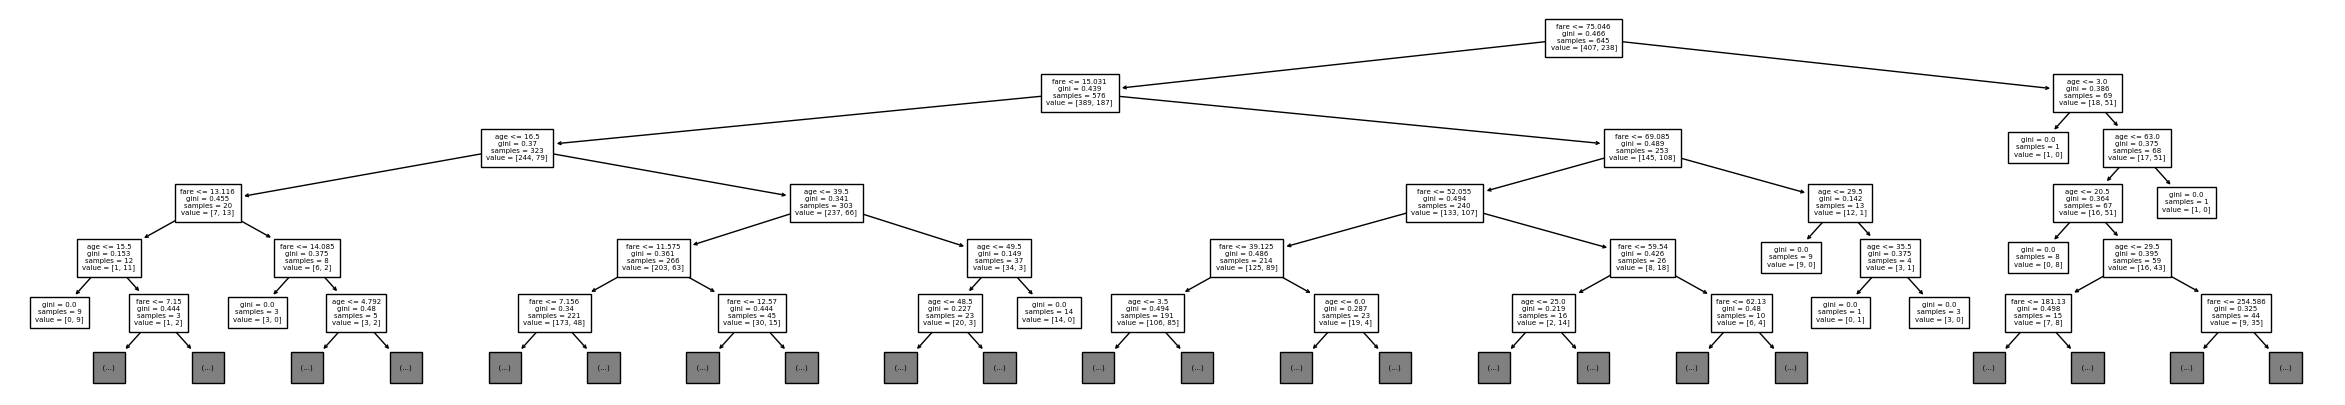

In [38]:
# Print the decision tree

# Create a figure and axis with a wider x-axis
fig, ax = plt.subplots(figsize=(30, 5))

# Plot the decision tree
sk.tree.plot_tree(pipeline.named_steps['classifier'],
               max_depth=5,
               feature_names=X,
               fontsize=5,
               ax=ax)

# Save average scores
avg_scores = dict()
avg_scores["sklearn"] = {
    "precision": np.mean(precisions),
    "recall": np.mean(recalls),
    "accuracy": np.mean(accuracies),
    "f1": np.mean(f1_scores),
    "std_precision": np.std(precisions),
    "std_recall": np.std(recalls),
    "std_accuracy": np.std(accuracies),
    "std_f1": np.std(f1_scores),
}

# Print average scores
print()
print("Average Scores:")
print(f"Precision: {avg_scores['sklearn']['precision']:.4f} (+/- {avg_scores['sklearn']['std_precision']:.4f})")
print(f"Recall: {avg_scores['sklearn']['recall']:.4f} (+/- {avg_scores['sklearn']['std_recall']:.4f})")
print(f"Accuracy: {avg_scores['sklearn']['accuracy']:.4f} (+/- {avg_scores['sklearn']['std_accuracy']:.4f})")
print(f"F1 Score: {avg_scores['sklearn']['f1']:.4f} (+/- {avg_scores['sklearn']['std_f1']:.4f})")

## Custom Approach

In [39]:
f1_by_k = dict()

# Perform k-fold cross-validation on different values of n_neighbors
for k in range(1, 5):
    n_neighbors = k
    print(f"n_neighbors = {n_neighbors}")
    fold = 1
    for train_index, test_index in kf.split(dataset):
        print(f"Fold {fold}")

        # Split the data
        train_data = dataset.iloc[train_index]
        test_data = dataset.iloc[test_index]

        # Estimate the probability mass function
        model = PMFRegressor(n_neighbors=n_neighbors)
        model.fit(train_data[X], train_data[y[0]])
        model.predict(test_data[X])

        # train_data.dropna(inplace=True)
        # test_data.dropna(inplace=True)

        # Make predictions
        y_true = test_data[y[0]].map(class_map)
        y_pred = pd.Series(model.predict(test_data[X])).map(class_map)

        # # Print the true and predicted classes
        # print("True Classes:")
        # print(y_true.head())
        # print("Predicted Classes:")
        # print(y_pred.head())

        # Calculate metrics using sklearn
        precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

        precisions.append(precision)
        recalls.append(recall)
        accuracies.append(accuracy)
        f1_scores.append(f1)

        # # Print the decision tree
        # print_tree(tree)
        # print()

        # print(f"Precision: {precision:.4f}")
        # print(f"Recall: {recall:.4f}")
        # print(f"Accuracy: {accuracy:.4f}")
        # print(f"F1 Score: {f1:.4f}")
        # print()

        # Increment the fold index
        fold += 1
        print("\n")

    # Save the n_neighbors value and evaluation metrics for this iteration
    #   if this value provides the highest f1 score
    mean_f1 = np.mean(f1_scores)
    if avg_scores.get("custom") is None:
        avg_scores["custom"] = {
            "n_neighbors": k,
            "precision": np.mean(precisions),
            "recall": np.mean(recalls),
            "accuracy": np.mean(accuracies),
            "f1": mean_f1,
            "std_precision": np.std(precisions),
            "std_recall": np.std(recalls),
            "std_accuracy": np.std(accuracies),
            "std_f1": np.std(f1_scores)
        }
    elif avg_scores["custom"]["f1"] < mean_f1:
        avg_scores["custom"] = {
            "n_neighbors": k,
            "precision": np.mean(precisions),
            "recall": np.mean(recalls),
            "accuracy": np.mean(accuracies),
            "f1": mean_f1,
            "std_precision": np.std(precisions),
            "std_recall": np.std(recalls),
            "std_accuracy": np.std(accuracies),
            "std_f1": np.std(f1_scores)
        }

    # Save the k and f1 values for this iteration
    f1_by_k[k] = mean_f1

f1_by_k = pd.DataFrame(f1_by_k.items(), columns=["k", "f1"])

n_neighbors = 1
Fold 1
X:
[[42.      7.11  ]
 [13.     20.05  ]
 [16.      7.13  ]
 [27.     18.1509]
 [27.      8.01  ]]
y:
[0 0 1 1 0]


Fold 2
X:
[[16.   20.05]
 [39.   20.05]
 [25.    7.13]
 [30.   24.  ]
 [28.   24.  ]]
y:
[0 1 1 0 1]


n_neighbors = 2
Fold 1
X:
[[42.      7.11  ]
 [13.     20.05  ]
 [16.      7.13  ]
 [27.     18.1509]
 [27.      8.01  ]]
y:
[0 0 1 1 0]


Fold 2
X:
[[16.   20.05]
 [39.   20.05]
 [25.    7.13]
 [30.   24.  ]
 [28.   24.  ]]
y:
[0 1 1 0 1]


n_neighbors = 3
Fold 1
X:
[[42.      7.11  ]
 [13.     20.05  ]
 [16.      7.13  ]
 [27.     18.1509]
 [27.      8.01  ]]
y:
[0 0 1 1 0]


Fold 2
X:
[[16.   20.05]
 [39.   20.05]
 [25.    7.13]
 [30.   24.  ]
 [28.   24.  ]]
y:
[0 1 1 0 1]


n_neighbors = 4
Fold 1
X:
[[42.      7.11  ]
 [13.     20.05  ]
 [16.      7.13  ]
 [27.     18.1509]
 [27.      8.01  ]]
y:
[0 0 1 1 0]


Fold 2
X:
[[16.   20.05]
 [39.   20.05]
 [25.    7.13]
 [30.   24.  ]
 [28.   24.  ]]
y:
[0 1 1 0 1]




### Results

In [40]:
print(f1_by_k.head())

   k        f1
0  1  0.649785
1  2  0.649240
2  3  0.648615
3  4  0.647910


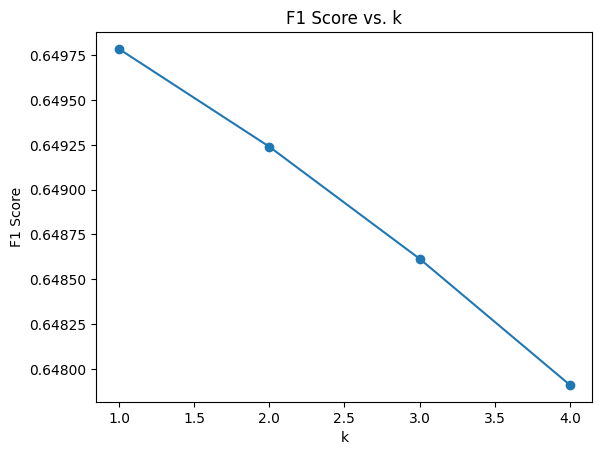

In [41]:
plt.plot(f1_by_k["k"], f1_by_k["f1"], marker='o') # Use plt.plot() for line plots
plt.title("F1 Score vs. k")
plt.xlabel("k")
plt.ylabel("F1 Score")
plt.show()

In [42]:
print(avg_scores)

{'sklearn': {'precision': 0.6626162540356437, 'recall': 0.6671729300078644, 'accuracy': 0.6671729300078644, 'f1': 0.645832870024711, 'std_precision': 0.027641427128321842, 'std_recall': 0.024257129551329346, 'std_accuracy': 0.024257129551329346, 'std_f1': 0.03474554560303192}, 'custom': {'n_neighbors': 1, 'precision': 0.6655264796677722, 'recall': 0.6700974455271727, 'accuracy': 0.6700974455271727, 'f1': 0.6497853153929393, 'std_precision': 0.028472088878481183, 'std_recall': 0.02550855390662547, 'std_accuracy': 0.02550855390662547, 'std_f1': 0.036224129818116735}}


In [43]:
# Print average scores
print()
print("Average Scores for Optimal k:")
print(f"n_neighbors = {avg_scores['custom']['n_neighbors']}")
print(f"Precision: {avg_scores['custom']['precision']:.4f} (+/- {avg_scores['custom']['std_precision']:.4f})")
print(f"Recall: {avg_scores['custom']['recall']:.4f} (+/- {avg_scores['custom']['std_recall']:.4f})")
print(f"Accuracy: {avg_scores['custom']['accuracy']:.4f} (+/- {avg_scores['custom']['std_accuracy']:.4f})")
print(f"F1 Score: {avg_scores['custom']['f1']:.4f} (+/- {avg_scores['custom']['std_f1']:.4f})")


Average Scores for Optimal k:
n_neighbors = 1
Precision: 0.6655 (+/- 0.0285)
Recall: 0.6701 (+/- 0.0255)
Accuracy: 0.6701 (+/- 0.0255)
F1 Score: 0.6498 (+/- 0.0362)


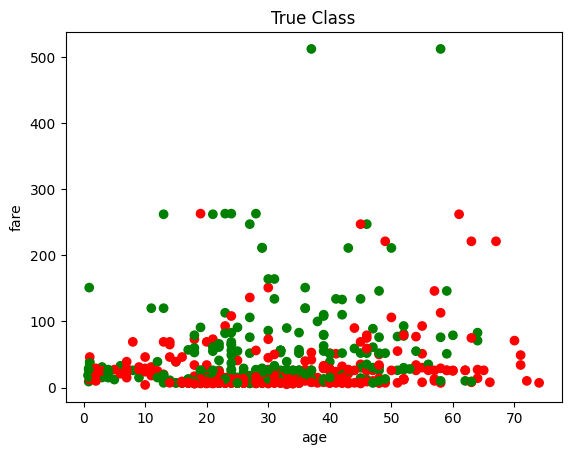

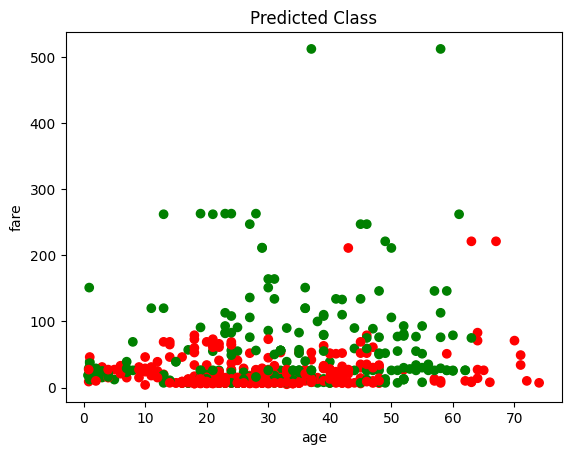

In [44]:
plt.scatter(test_data[X[0]], test_data[X[1]], c=test_data[y[0]].map(colormap))

# Add labels and title
plt.title("True Class")
plt.xlabel(X[0])
plt.ylabel(X[1])
plt.show()

plt.scatter(test_data[X[0]], test_data[X[1]], c=y_pred.map(colormap))

# Add labels and title
plt.title("Predicted Class")
plt.xlabel(X[0])
plt.ylabel(X[1])
plt.show()

## Compare Models

In [45]:
for model_name, scores in avg_scores.items():
      print(f"{model_name}:")
      print(f"Precision: {scores['precision']:.4f} (+/- {scores['std_precision']:.4f})")
      print(f"Recall: {scores['recall']:.4f} (+/- {scores['std_recall']:.4f})")
      print(f"Accuracy: {scores['accuracy']:.4f} (+/- {scores['std_accuracy']:.4f})")
      print(f"F1 Score: {scores['f1']:.4f} (+/- {scores['std_f1']:.4f})")
      print()

sklearn:
Precision: 0.6626 (+/- 0.0276)
Recall: 0.6672 (+/- 0.0243)
Accuracy: 0.6672 (+/- 0.0243)
F1 Score: 0.6458 (+/- 0.0347)

custom:
Precision: 0.6655 (+/- 0.0285)
Recall: 0.6701 (+/- 0.0255)
Accuracy: 0.6701 (+/- 0.0255)
F1 Score: 0.6498 (+/- 0.0362)

